In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [67]:
marketing = pd.read_csv('Cust_Records.csv')
marketing.columns

Index(['Age', 'Education', 'Relationship_Status', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One', 'Cust_Accept (%)'],
      dtype='object')

In [68]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 20 columns):
Age                    2227 non-null int64
Education              2227 non-null object
Relationship_Status    2227 non-null object
Income                 2227 non-null float64
Children               2227 non-null int64
Wine ($)               2227 non-null int64
Fruit ($)              2227 non-null int64
Meat ($)               2227 non-null int64
Fish ($)               2227 non-null int64
Sweets ($)             2227 non-null int64
Gold_Products ($)      2227 non-null int64
Discount_Purchases     2227 non-null int64
Web_Purchases          2227 non-null int64
Catalog_Purchases      2227 non-null int64
Store_Purchases        2227 non-null int64
Days_Enrolled          2227 non-null float64
Avg_Purch_Freq         2227 non-null float64
Avg_Spend ($)          2227 non-null float64
Accept_One             2227 non-null int64
Cust_Accept (%)        2227 non-null float64
dtypes: float64(5), i

*Preprocessing for Customer Segmentation / Classification / Regression Below*

In [69]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

marketing_ml = marketing.drop(['Accept_One', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)

### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml, columns=['Education', 'Relationship_Status'], drop_first=False)

### Appending the categorical features to end on unskewed DF ###
ml = pd.concat([numerical, categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']]], axis=1)
print(ml.head(1))



          0         1         2         3         4        5        6  \
0  0.989123  0.437415 -1.438334  0.986611  1.431069  1.39743  1.57789   

          7         8         9  ...  Education_2n Cycle  Education_Basic  \
0  1.407776  1.060355  0.651735  ...                   0                0   

   Education_Graduation  Education_Master  Education_PhD  \
0                     1                 0              0   

   Relationship_Status_Divorced  Relationship_Status_In-Relationship  \
0                             0                                    0   

   Relationship_Status_Married  Relationship_Status_Single  \
0                            0                           1   

   Relationship_Status_Widow  
0                          0  

[1 rows x 26 columns]


Text(0.5, 1.0, 'Elbow Plot')

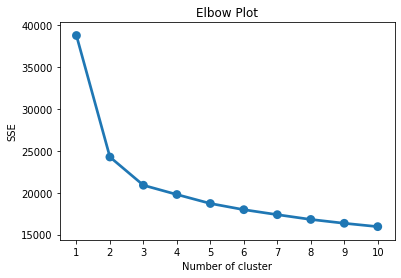

In [70]:
from sklearn.cluster import KMeans
import seaborn as sns

X = ml
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('Elbow Plot')

In [71]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml)
labels = kmeans.labels_
marketing['Cluster'] = labels
print('Cluster Counts')
print(marketing['Cluster'].value_counts())
education = marketing.groupby(['Cluster', 'Education'])['Education'].count()
print('\nPercentage of Cluster Totals by Education')
print(round((education / education.groupby(level=0).sum()) * 100))
relationship = marketing.groupby(['Cluster', 'Relationship_Status'])['Education'].count()
print('\nPercentage of Cluster Totals by Relationship Status')
print(round((relationship / relationship.groupby(level=0).sum()) * 100))
print('\nNumerical Data - Grouped by Cluster (Means)')
marketing.groupby('Cluster').mean()

Cluster Counts
1    853
0    722
2    652
Name: Cluster, dtype: int64

Percentage of Cluster Totals by Education
Cluster  Education 
0        2n Cycle       9.0
         Basic          0.0
         Graduation    55.0
         Master        15.0
         PhD           20.0
1        2n Cycle      11.0
         Basic          6.0
         Graduation    48.0
         Master        16.0
         PhD           19.0
2        2n Cycle       6.0
         Graduation    48.0
         Master        20.0
         PhD           26.0
Name: Education, dtype: float64

Percentage of Cluster Totals by Relationship Status
Cluster  Relationship_Status
0        Divorced               10.0
         In-Relationship        25.0
         Married                38.0
         Single                 23.0
         Widow                   5.0
1        Divorced                9.0
         In-Relationship        25.0
         Married                39.0
         Single                 23.0
         Widow              

,Age,Income,Children,Wine ($),Fruit ($),Meat ($),Fish ($),Sweets ($),Gold_Products ($),Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,Days_Enrolled,Avg_Purch_Freq,Avg_Spend ($),Accept_One,Cust_Accept (%)
Cluster,,,,,,,,,,,,,,,,,,
0,45.970914,72660.262605,0.315789,588.490305,63.934903,394.867036,92.522161,65.000000,76.650970,1.447368,5.452909,5.483380,8.469529,473.970914,23.935387,63.497101,0.426593,13.850416
1,41.783118,32789.066114,1.245018,24.318875,3.720985,18.848769,5.234467,4.490035,12.906213,1.841735,1.839390,0.424385,2.909730,481.307151,77.834633,9.415135,0.132474,2.735444
2,48.415644,53925.580408,1.271472,356.641104,14.311350,107.467791,19.226994,14.943252,48.857362,3.944785,5.544479,2.489264,6.639571,473.257669,27.373839,28.665282,0.280675,6.543967


We see that one particular group had 43% of customers accept the offer at least once while also containing an average customer acceptance percentage of 14%. 

The next most promising group had 28% of customers accept the offer at least once while also containing an average customer acceptance percentage of 7%.

Least promising group had 13% of customers accept the offer at least once while also containing an average customer acceptance percentage of 3%. 

**Classification - 1)Predict Acceptance of one offer  2) Predict amount of times out of six (probability)**

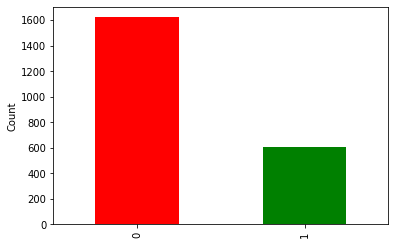

0    1623
1     604
Name: Accept_One, dtype: int64


In [72]:
### Imbalanced Classification Targets ###
my_colors = ['red', 'green']
marketing['Accept_One'].value_counts().plot(kind='bar', color=my_colors)
plt.ylabel('Count')
plt.show()
print(marketing['Accept_One'].value_counts())

In [73]:
### Classifier utilizing no imbalancing techniques - SVM ###
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

X = ml.values
y = marketing['Accept_One'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
params = {'C' : [.001, .01, 0.1, 1, 10, 100]}
SVM = svm.SVC(kernel='linear')
grid_search = GridSearchCV(SVM, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_class = grid_search.best_estimator_
y_pred = best_class.predict(X_test)
print(best_class.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


{'C': 10}
0.7576301615798923
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       399
           1       0.68      0.28      0.39       158

    accuracy                           0.76       557
   macro avg       0.72      0.61      0.62       557
weighted avg       0.74      0.76      0.72       557

[[378  21]
 [114  44]]


^^ Recall was poor for the accepted offer class (1). There were more false negatives compared to true positives (model more often predicted non-acceptance when it really was accepted). Model overfitted towards non-acceptance (0). 

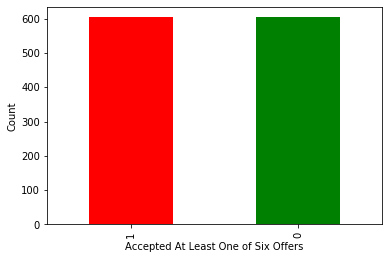

1    604
0    604
dtype: int64


In [74]:
### Undersampling ###
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
acceptance = pd.Series(y_resampled)
acceptance.value_counts().plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())


In [75]:
### Classifier Using Undersampling ###
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=42)
params = {'C' : [.001, .01, 0.1, 1, 10, 100]}
SVM = svm.SVC(kernel='linear')
grid_search = GridSearchCV(SVM, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_class = grid_search.best_estimator_
y_pred = best_class.predict(X_test)
print(best_class.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

{'C': 0.1}
0.7152317880794702
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       158
           1       0.71      0.67      0.69       144

    accuracy                           0.72       302
   macro avg       0.72      0.71      0.71       302
weighted avg       0.72      0.72      0.71       302

[[119  39]
 [ 47  97]]


^^ Model's recall for acceptance (1) is much improved. Accuracy did not suffer much and neither did precision (which slightly improved for (1)). Average f1-score improved as a result

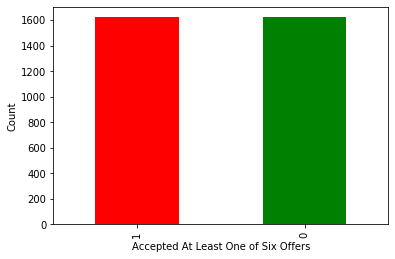

1    1623
0    1623
dtype: int64


In [76]:
### Oversampling ###

from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X, y)
acceptance = pd.Series(y_sm)
acceptance.value_counts().plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())

In [77]:
### Classifier Using Oversampling ###
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=.25, random_state=42)
params = {'C' : [.001, .01, 0.1, 1, 10, 100]}
SVM = svm.SVC(kernel='linear')
grid_search = GridSearchCV(SVM, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_class = grid_search.best_estimator_
y_pred = best_class.predict(X_test)
print(best_class.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

{'C': 100}
0.7438423645320197
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       431
           1       0.70      0.80      0.74       381

    accuracy                           0.74       812
   macro avg       0.75      0.75      0.74       812
weighted avg       0.75      0.74      0.74       812

[[301 130]
 [ 78 303]]


^^ In printing results for both undersampling and oversampling, I favor undersampling's average metrics from the classification report. Accuracy score was not worse by much at all either

**After classifying a customer as Accepted (1), classify their offer acceptance rate (indicates customers that are most likely to accept the offer each time it is sent out)**

In [87]:
### Adding Accept_Rate Labels ###
marketing['Accept_Rate'] = ''
for idx, row in marketing.iterrows():
    if row['Cust_Accept (%)'] == 0:
        marketing.loc[idx, 'Accept_Rate'] = 'Zero'
    elif row['Cust_Accept (%)'] == ((1/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '1/6'
    elif row['Cust_Accept (%)'] == ((2/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '2/6'
    elif row['Cust_Accept (%)'] == ((3/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '3/6'
    elif row['Cust_Accept (%)'] == ((4/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '4/6'
    elif row['Cust_Accept (%)'] == ((5/6) * 100):
            marketing.loc[idx, 'Accept_Rate'] = '5/6'
        

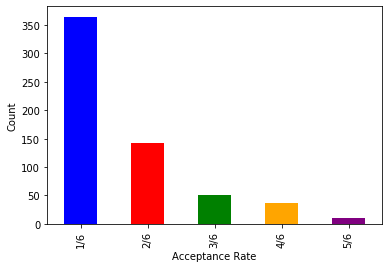

Accept_Rate
1/6    365
2/6    142
3/6     51
4/6     36
5/6     10
Name: Accept_Rate, dtype: int64


In [91]:
### Distribution of Those Who Accepted At Least One Offer ###
accepted = marketing.loc[~(marketing['Accept_Rate'] == 'Zero')]
my_colors = ['blue', 'red', 'green', 'orange', 'purple']
accepted.groupby('Accept_Rate')['Accept_Rate'].count().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance Rate')
plt.ylabel('Count')
plt.show()
print(accepted.groupby('Accept_Rate')['Accept_Rate'].count())

In [ ]:
### Numerically Encode Accept_Rate ###
for idx, row in accepted.iterrows():
    if row['Accept_Rate'] == '1/6':
        accepted.loc[idx, 'Accept_Rate'] = 1
    elif row['Accept_Rate'] == '2/6':
        accepted.loc[idx, 'Accept_Rate'] = 2
    elif row['Accept_Rate'] == '3/6':
        accepted.loc[idx, 'Accept_Rate'] = 3
    elif row['Accept_Rate'] == '4/6':
        accepted.loc[idx, 'Accept_Rate'] = 4
    elif row['Accept_Rate'] == '5/6':
        accepted.loc[idx, 'Accept_Rate'] = 5


In [ ]:
### Classifier for Accept_Rate ###
X = ml.values
y = accepted['Accept_Rate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
params = {'C' : [.001, .01, 0.1, 1, 10, 100]}
SVM = svm.SVC(kernel='linear')
grid_search = GridSearchCV(SVM, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_class = grid_search.best_estimator_
y_pred = best_class.predict(X_test)
print(best_class.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

*Regression to Predict Cust_Accept (%)*

In [89]:
### Random Forest Regressor, HyperParameter Tuning ###
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = ml.values
y = marketing['Cust_Accept (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
rfr = RandomForestRegressor(n_jobs=-1, oob_score=True)
grid_search = GridSearchCV(rfr, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False, scoring = 'r2')
grid_search.fit(X_train, y_train)
y_pred_test = grid_search.predict(X_test)
best_rfr = grid_search.best_estimator_


 *Most Important Education Category*
                 cols       imp
 Education_Graduation  0.008699

 *Most Important Relationship_Status Category*
                        cols       imp
 Relationship_Status_Married  0.006926

 *Most Important Purchases Category*
              cols       imp
 Catalog_Purchases  0.050014

 *Most Important ($) Category*
     cols       imp
 Wine ($)  0.174912


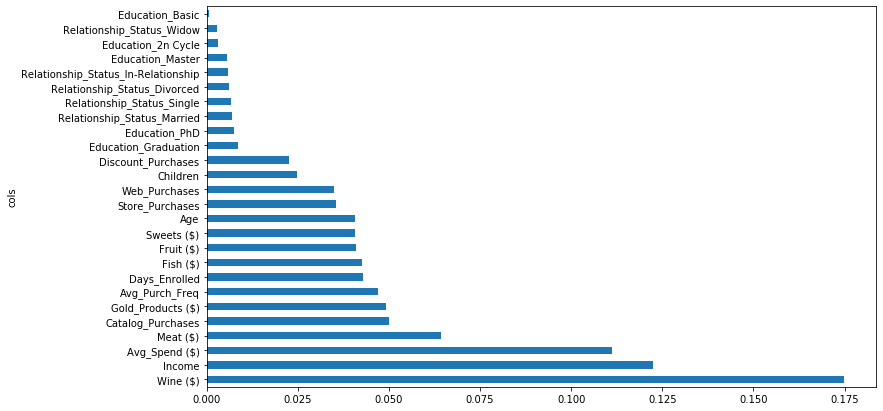


OOB Score:  0.4350199843157163

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}

Testing RMSE: 10.366984795650158

Testing R2:  0.4331103900048644


In [90]:
### Analyzing Performance & Feature Importance Towards Cust Accept % ###

from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

fi = rf_feat_importance(best_rfr, categorical)
for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
    print('\n', '*Most Important', feature, 'Category*' )
    new = fi.loc[fi['cols'].str.contains(feature)]
    print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_rfr.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', grid_search.score(X_test, y_test))